<h1 align="center">     Driving Behavior </h1> 













#Dataset despcription

Context
Driver behavior is one of the most important aspects in the design, development, and application of Advanced Driving Assistance Systems (ADAS) and Intelligent Transportation Systems (ITS), which can be affected by many factors. If you are able to measure the driving style of your staff, there is a lot of actions you can take in order to improve fleet safety, global road safety as well as fuel efficiency and emissions.

Content
Dataset for modeling risky driver behaviors based on accelerometer (X, Y, Z axis in meters per second squared (m/$s^2$)) and gyroscope (X, Y, Z axis in degrees per second (°/s) ) data.
* Sampling Rate: Average 2 samples (rows) per second.
* Cars: Ford Fiesta 1.4, Ford Fiesta 1.25, Hyundai i20.
* Drivers: 3 different drivers with the ages of 27, 28 and 37.
* Best Window Size: 14 seconds
* Sensor: MPU6050
* Device: Raspberry Pi 3 Model B
> Driver Behaviors:

1.   Sudden Acceleration (Class Label: 1)
2.   Sudden Right Turn (Class Label: 2)
3. Sudden Left Turn (Class Label: 3)
4. Sudden Break (Class Label: 4)


> Acknowledgements:
> > Yuksel, Asim; Atmaca, Şerafettin (2020), “Driving Behavior Dataset”, Mendeley Data, V2, doi: 10.17632/jj3tw8kj6h.2

# Exploring the dataset

In [1]:
import numpy as np
import pandas as pd
import itertools

from sklearn import datasets
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from imblearn.over_sampling import RandomOverSampler 

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from mlxtend.plotting import plot_decision_regions
from mlxtend.preprocessing import shuffle_arrays_unison
import seaborn as sns

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz
from six import StringIO  
from IPython.display import Image  
import pydotplus

%pip install umap-learn
import umap
from sklearn.cluster import DBSCAN
from sklearn.utils.class_weight import compute_sample_weight


In [2]:
#put your path here
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Colab Notebooks/Na GITa/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks/Na GITa


In [32]:
df = pd.read_csv("data/features_14.csv")
df.sample(10)

,Target,AccMeanX,AccMeanY,AccMeanZ,AccCovX,AccCovY,AccCovZ,AccSkewX,AccSkewY,AccSkewZ,...,GyroMaxZ,GyroVarX,GyroVarY,GyroVarZ,GyroMedianX,GyroMedianY,GyroMedianZ,GyroStdX,GyroStdY,GyroStdZ
767,3,0.283098,0.036743,-0.904890,0.011552,0.034228,0.011752,-0.364368,0.704270,0.250482,...,39.969466,23.687894,11.392643,205.027955,-2.503817,4.950382,3.087786,4.867021,3.375299,14.318797
294,2,0.191860,-0.155273,-0.988752,0.026097,0.031141,0.007642,-0.455493,-1.200395,-2.142299,...,5.603053,22.539385,17.384211,197.686310,-0.629771,3.973282,1.045802,4.747566,4.169438,14.060096
752,3,0.252930,0.018345,-0.978899,0.008572,0.040229,0.013315,1.141492,0.580952,-0.787435,...,39.664122,13.829020,7.892912,200.860948,-0.725191,5.015267,4.278626,3.718739,2.809433,14.172542
101,1,0.318168,-0.134713,-1.019182,0.030088,0.008036,0.010562,0.160120,-0.055554,-1.257143,...,7.335878,9.664799,3.601365,4.832180,-0.732824,3.977099,0.866412,3.108826,1.897726,2.198222
148,1,0.278809,-0.118705,-1.007167,0.025476,0.002546,0.015236,0.207430,0.907636,-0.469296,...,3.717557,5.372441,6.485159,1.869816,-1.332061,3.095420,0.885496,2.317853,2.546597,1.367412
383,2,0.179356,-0.196062,-0.989746,0.032450,0.068434,0.008794,-0.833701,-1.465467,0.154846,...,5.809160,22.263959,32.542084,290.333626,-2.500000,4.480916,0.484733,4.718470,5.704567,17.039179
124,1,0.263410,-0.073765,-0.952462,0.027254,0.011381,0.011947,0.411344,0.716687,2.203719,...,4.625954,20.956594,19.014256,1.714717,-0.301527,5.328244,0.874046,4.577837,4.360534,1.309472
485,2,0.170776,-0.200352,-0.977661,0.031026,0.015976,0.003055,-0.548725,-0.641626,0.349379,...,2.549618,9.343526,20.811882,161.773020,-0.927481,2.812977,-0.473282,3.056718,4.562004,12.719002
471,2,0.141078,-0.232718,-0.964495,0.036635,0.023836,0.016832,0.117015,-0.886689,-0.236569,...,2.839695,8.000768,12.835818,271.694499,-0.183206,3.206107,0.935115,2.828563,3.582711,16.483158
183,1,0.412319,-0.165754,-0.916783,0.012214,0.005869,0.029642,-0.778320,-1.389826,1.647106,...,3.763359,22.046195,7.593415,3.385184,-2.190840,2.221374,0.835878,4.695338,2.755615,1.839887


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1102 entries, 0 to 1101
Data columns (total 61 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Target       1102 non-null   int64  
 1   AccMeanX     1102 non-null   float64
 2   AccMeanY     1102 non-null   float64
 3   AccMeanZ     1102 non-null   float64
 4   AccCovX      1102 non-null   float64
 5   AccCovY      1102 non-null   float64
 6   AccCovZ      1102 non-null   float64
 7   AccSkewX     1102 non-null   float64
 8   AccSkewY     1102 non-null   float64
 9   AccSkewZ     1102 non-null   float64
 10  AccKurtX     1102 non-null   float64
 11  AccKurtY     1102 non-null   float64
 12  AccKurtZ     1102 non-null   float64
 13  AccSumX      1102 non-null   float64
 14  AccSumY      1102 non-null   float64
 15  AccSumZ      1102 non-null   float64
 16  AccMinX      1102 non-null   float64
 17  AccMinY      1102 non-null   float64
 18  AccMinZ      1102 non-null   float64
 19  AccMax

## Finding correlations

In [33]:
lower_tri = df.corr().where(np.tril(np.ones(df.corr().shape),k=0).astype(bool))

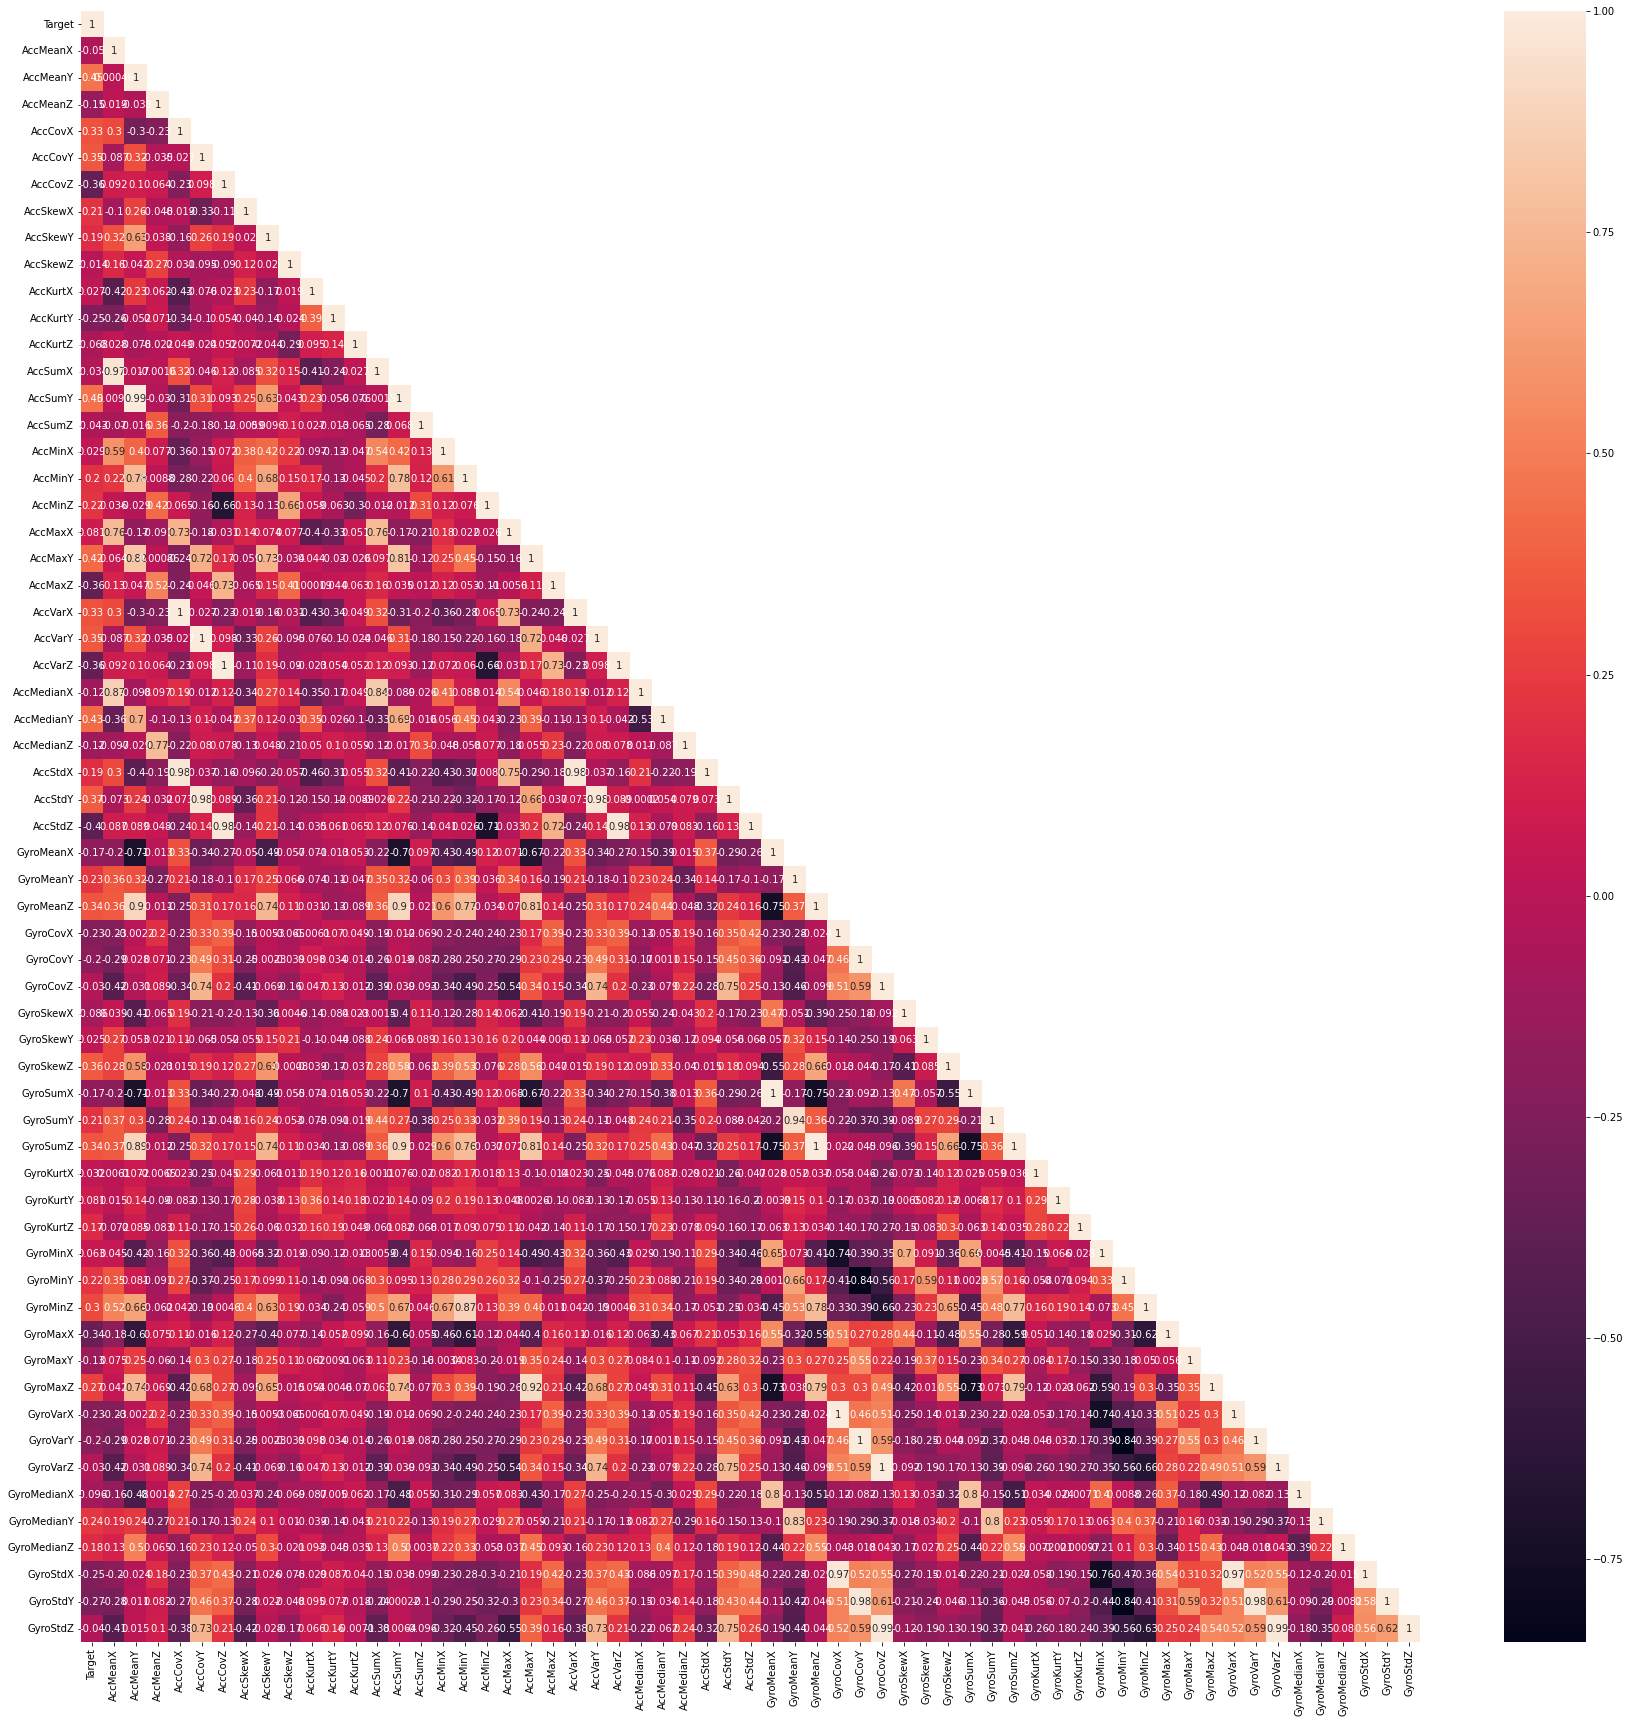

In [ ]:
plt.figure(figsize=(30, 30))
sns.heatmap(lower_tri, annot=True)
plt.show()

**Deleting high correlation features to reduce time for unnecessary computations.**

In [34]:
correlation = lower_tri.abs().unstack().sort_values(ascending=False)
high_corr = correlation[correlation>0.89].dropna()
high_corr_features = [list(high_corr.index)[i][0] for i in range(len(high_corr)) if list(high_corr.index)[i][0] != list(high_corr.index)[i][1]] 
df_clear = df.drop(columns=high_corr_features)

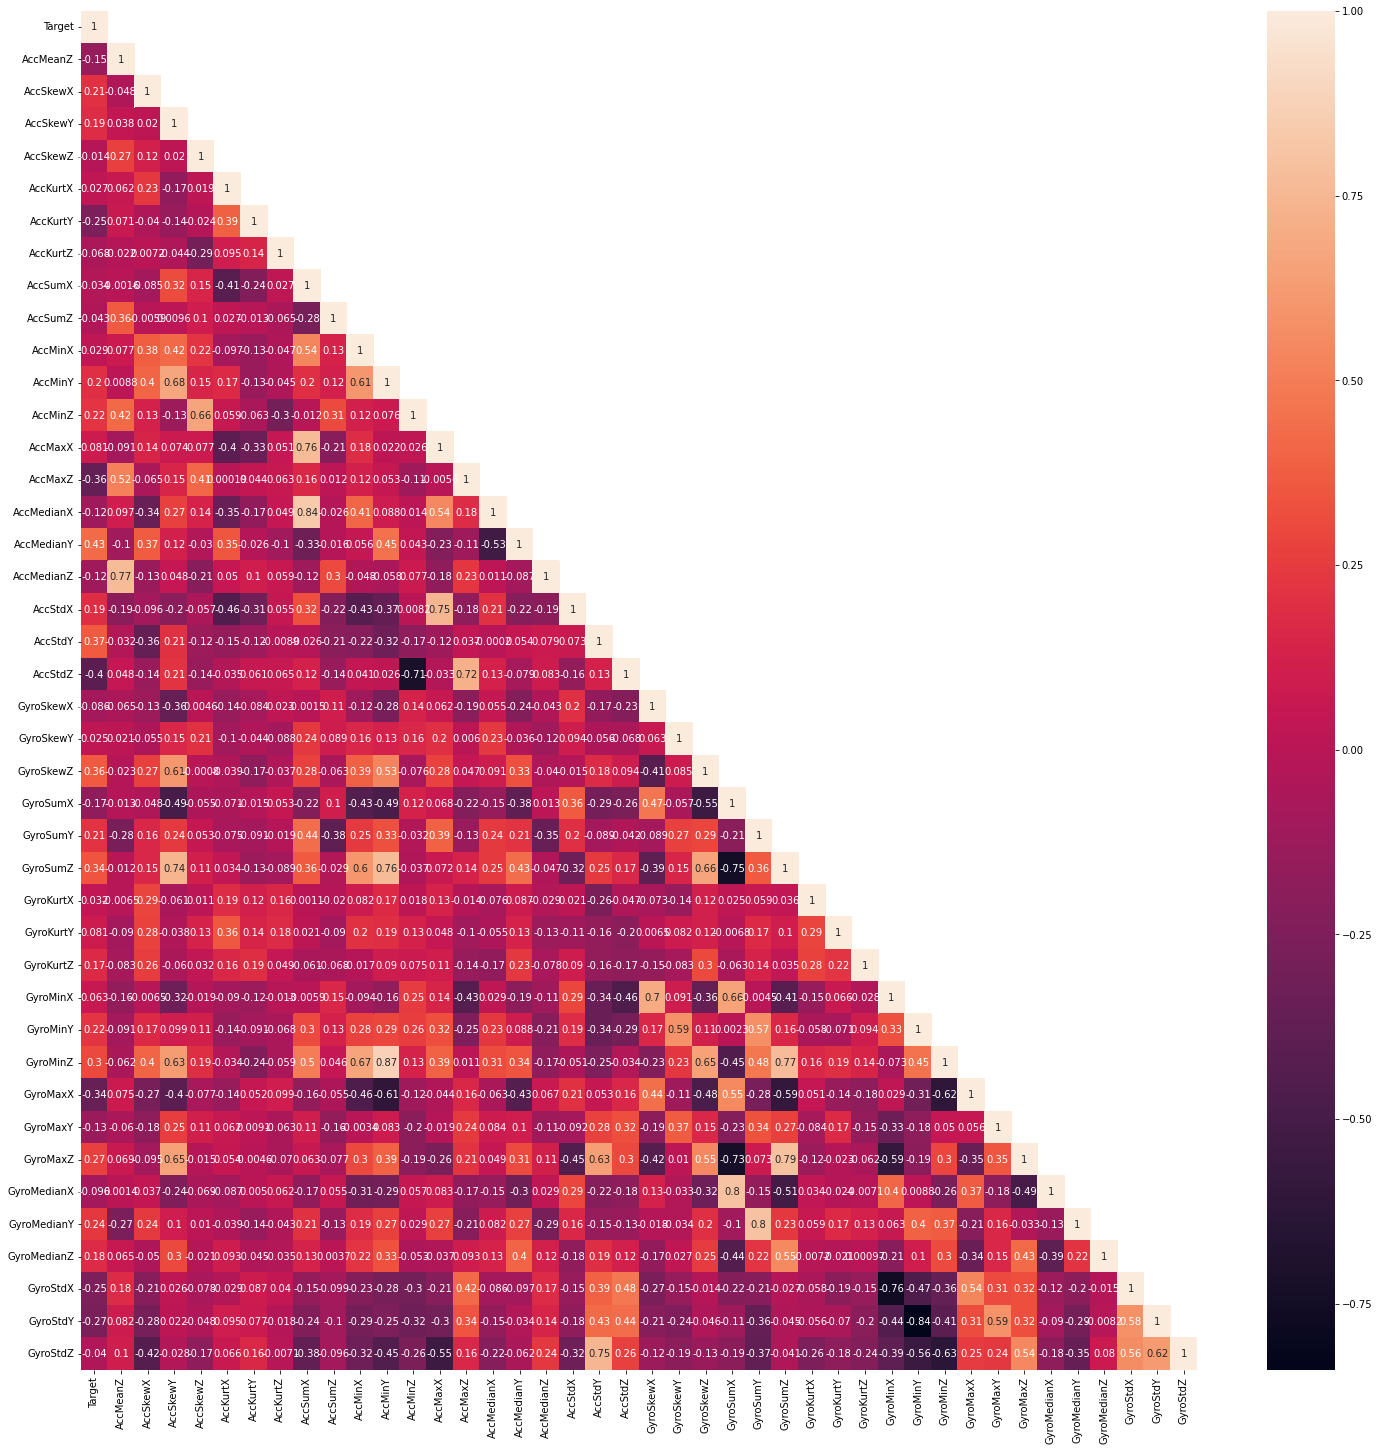

In [ ]:
plt.figure(figsize=(25, 25))
sns.heatmap(df_clear.corr().where(np.tril(np.ones(df_clear.corr().shape),k=0).astype(bool)), annot=True)
plt.show()

## Any null values?

In [ ]:
df_clear.isna().any()

Target         False
AccMeanZ       False
AccSkewX       False
AccSkewY       False
AccSkewZ       False
AccKurtX       False
AccKurtY       False
AccKurtZ       False
AccSumX        False
AccSumZ        False
AccMinX        False
AccMinY        False
AccMinZ        False
AccMaxX        False
AccMaxZ        False
AccMedianX     False
AccMedianY     False
AccMedianZ     False
AccStdX        False
AccStdY        False
AccStdZ        False
GyroSkewX      False
GyroSkewY      False
GyroSkewZ      False
GyroSumX       False
GyroSumY       False
GyroSumZ       False
GyroKurtX      False
GyroKurtY      False
GyroKurtZ      False
GyroMinX       False
GyroMinY       False
GyroMinZ       False
GyroMaxX       False
GyroMaxY       False
GyroMaxZ       False
GyroMedianX    False
GyroMedianY    False
GyroMedianZ    False
GyroStdX       False
GyroStdY       False
GyroStdZ       False
dtype: bool

In [ ]:
df_clear

,Target,AccMeanZ,AccSkewX,AccSkewY,AccSkewZ,AccKurtX,AccKurtY,AccKurtZ,AccSumX,AccSumZ,...,GyroMinZ,GyroMaxX,GyroMaxY,GyroMaxZ,GyroMedianX,GyroMedianY,GyroMedianZ,GyroStdX,GyroStdY,GyroStdZ
0,1,-0.957764,0.867594,-1.305868,-0.507254,-1.164806,1.239840,-0.761065,1.141357,-3.831055,...,-0.251908,0.786260,4.564885,0.832061,-0.286260,4.251908,0.706107,0.872422,0.429385,0.512697
1,1,-0.956250,0.002474,-0.395088,-0.677572,-2.649441,-2.649803,0.636762,1.567383,-4.781250,...,-0.251908,3.351145,4.564885,0.832061,0.335878,3.969466,0.587786,1.749594,0.765501,0.519942
2,1,-0.950155,-0.354212,-0.603657,-0.984635,-1.819232,-1.472251,0.663006,1.951172,-5.700928,...,-1.656489,3.351145,4.564885,0.832061,-0.286260,3.832061,0.240458,1.771179,0.743257,0.951587
3,1,-0.937640,-0.655653,-0.152454,-0.040530,-1.214712,-2.185485,0.666209,2.355957,-6.563477,...,-1.656489,3.351145,8.725191,0.832061,0.335878,3.969466,-0.106870,1.676163,1.990743,0.945054
4,1,-0.941681,-0.718488,-0.446061,0.250539,-0.666622,-1.909540,0.556116,2.702881,-7.533447,...,-1.656489,3.351145,8.725191,0.832061,-0.286260,4.038168,-0.179389,1.633269,1.847808,0.894308
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1097,4,-0.983939,0.458098,-0.614773,0.529063,-1.655437,-1.078165,0.931743,3.825195,-13.775146,...,0.137405,3.396947,6.648855,8.893130,-0.500000,4.526718,1.083969,1.459337,1.311542,2.207612
1098,4,-0.976266,0.479824,-0.640988,1.008758,-1.515821,-0.986868,1.370188,3.705566,-13.667725,...,0.137405,3.396947,5.572519,8.893130,-0.500000,4.526718,1.083969,1.432459,1.178880,2.134740
1099,4,-0.976039,0.532820,-0.673323,1.009590,-1.295757,-0.894073,1.407331,3.599365,-13.664551,...,0.137405,3.396947,5.572519,8.893130,-0.500000,4.522901,1.083969,1.416403,1.173977,2.137460
1100,4,-0.978446,0.532226,-0.672990,0.987714,-1.296626,-0.894416,1.066259,3.599854,-13.698242,...,0.137405,3.396947,5.572519,8.893130,-0.500000,4.538168,1.083969,1.428826,1.203513,2.145522


In [ ]:
df_clear.duplicated(keep='first').any()

False

##Is dataset balanced?

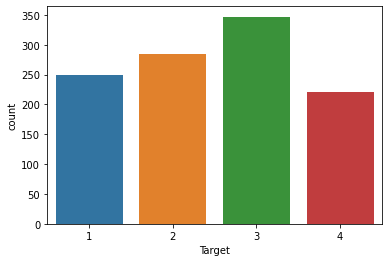

In [ ]:
sns.countplot(x='Target',data=df_clear)

###Dealing with unbalanced data
Random over-sampling with imblearn
Tomek links jesli DT sie nie da na wiecej niz 3 labele - trzeba znormalizowac

In [ ]:
ros = RandomOverSampler(random_state=33)

X_ros, y_ros = ros.fit_resample(df_clear.iloc[:, 1:], df_clear.iloc[:,0])

data_ros = pd.concat([y_ros, X_ros], axis=1)


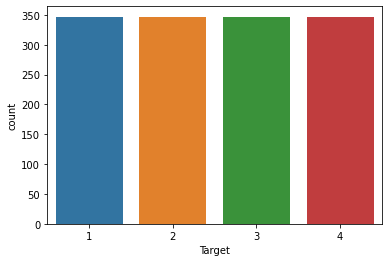

In [ ]:
sns.countplot(x='Target', data=data_ros)

## Data Seperating, Encoding, and Standarization

In [ ]:
df_clear=data_ros
X=df_clear.iloc[:, 1:]
y=df_clear.iloc[:,0]


## Standarization
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

## Splitting

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=33)


# SUPPORT VECTOR MACHINE

## Running SVM with default hyperparamters

In [ ]:
svc=SVC() #Default hyperparameters
classifier = svc.fit(X_train, y_train)

y_pred = classifier.predict(X_test)
print('Accuracy Score for default parameters:')
print(metrics.accuracy_score(y_test,y_pred))

Accuracy Score for default parameters:
0.9913544668587896


## Running SVM with different Kernels but with their default hyperparameters

In [ ]:
svc=SVC(kernel='linear')
svc.fit(X_train,y_train)
y_pred=svc.predict(X_test)
print('Accuracy Score Linear:')
print(metrics.accuracy_score(y_test,y_pred))
svc=SVC(kernel='rbf')
svc.fit(X_train,y_train)
y_pred=svc.predict(X_test)
print('Accuracy Score RBF:')
print(metrics.accuracy_score(y_test,y_pred))
svc=SVC(kernel='poly')
svc.fit(X_train,y_train)
y_pred=svc.predict(X_test)
print('Accuracy Score Polynomial:') 
print(metrics.accuracy_score(y_test,y_pred))

Accuracy Score Linear:
0.9884726224783862
Accuracy Score RBF:
0.9913544668587896
Accuracy Score Polynomial:
0.9740634005763689


**From the above analysis, we will investigate different hyperparameters for Linear and RBF kernels only, since Polynomial performance is the worst.**

## Trying different combinations:

## CV with Linear Kernel

In [ ]:
svc=SVC(kernel='linear')
scores = cross_val_score(svc, X_train, y_train, cv=10, scoring='accuracy') #cv is cross validation
print(scores)
print(scores.mean())

[0.98095238 1.         0.99038462 1.         1.         0.99038462
 1.         0.98076923 1.         1.        ]
0.9942490842490843


## CV with RBF Kernel

In [ ]:
svc=SVC(kernel='rbf')
scores = cross_val_score(svc, X_train, y_train, cv=10, scoring='accuracy') #cv is cross validation
print(scores)
print(scores.mean())

[1.         1.         1.         1.         0.99038462 1.
 0.99038462 0.99038462 1.         1.        ]
0.9971153846153846


**In order to show as much information as possible on 2D plots we use PCA for 2 main components.**

In [ ]:
pca = PCA(n_components = 2)
X_train_pca = pca.fit_transform(X_train)

/usr/local/lib/python3.7/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())
/usr/local/lib/python3.7/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())
/usr/local/lib/python3.7/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())
/usr/local/lib/python3.7/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(),

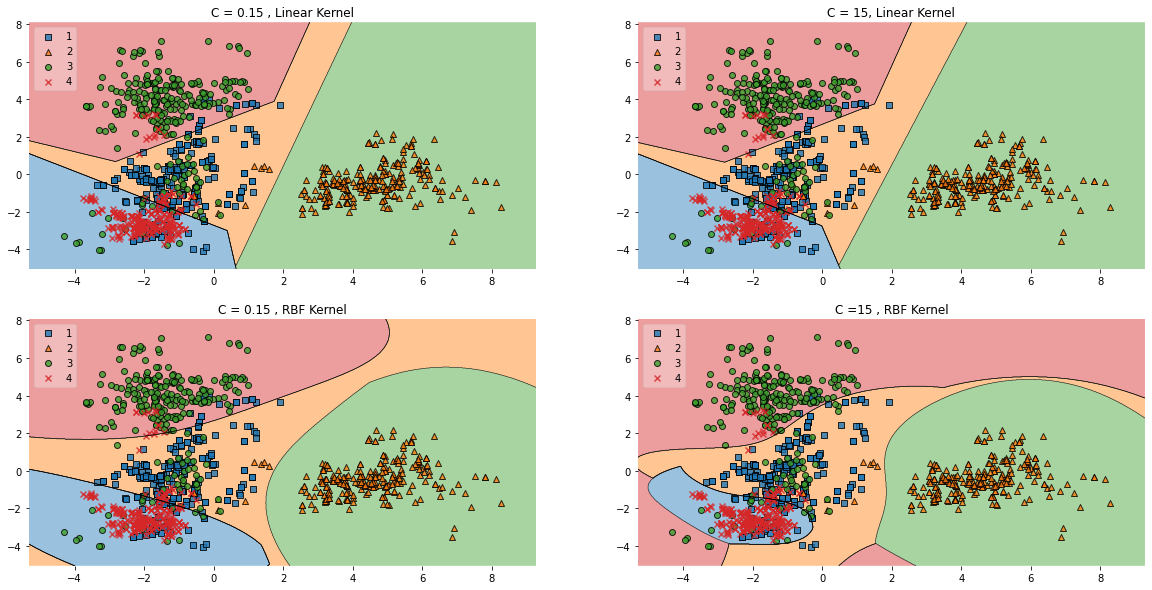

In [ ]:
gs = gridspec.GridSpec(2, 2)

plt.rcParams['figure.figsize'] = (20, 10)

clf1 = SVC(C=0.15, kernel='linear')
clf2 = SVC(C=15, kernel='linear')
clf3 = SVC(C=0.15, kernel='rbf')
clf4 = SVC(C=15, kernel='rbf')
scatter_highlight_kwargs = {'s': 50, 'label': 'Test data', 'alpha': 0.7, 'linestyle':'-'}

labels = ['C = 0.15 , Linear Kernel' , 'C = 15, Linear Kernel', 'C = 0.15 , RBF Kernel'  ,'C =15 , RBF Kernel']
for clf, lab, grd in zip([clf1, clf2, clf3, clf4],
                         labels,
                         itertools.product([0, 1], repeat=2)):

    clf.fit(X_train_pca, y_train)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X_train_pca, y=np.asarray(y_train), clf=clf, legend=2)
    plt.title(lab)

plt.show()

## Checking the C hyperparameter in depth for the RBF Kernel

[0.9971153846153846, 0.9990384615384615, 0.9990384615384615, 0.9990384615384615, 0.9990384615384615, 0.9990384615384615, 0.9990384615384615, 0.9990384615384615, 0.9990384615384615, 0.9990384615384615, 0.9990384615384615, 0.9990384615384615, 0.9990384615384615, 0.9990384615384615, 0.9990384615384615, 0.9990384615384615, 0.9990384615384615, 0.9990384615384615, 0.9990384615384615, 0.9990384615384615]


Text(0, 0.5, 'Cross-Validated Accuracy')

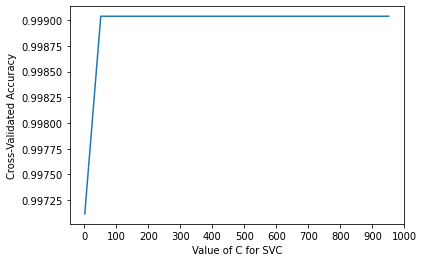

In [ ]:
C_range=list(range(1,1000,50))
acc_score=[]
for c in C_range:
    svc = SVC(kernel='rbf', C=c)
    scores = cross_val_score(svc, X_train, y_train, cv=10, scoring='accuracy')
    acc_score.append(scores.mean())
print(acc_score)    
# plot the value of C for SVM (x-axis) versus the cross-validated accuracy (y-axis)
plt.plot(C_range,acc_score)
plt.xticks(np.arange(0,1100,100))
plt.xlabel('Value of C for SVC')
plt.ylabel('Cross-Validated Accuracy')

**From the above plot we can see that accuracy has been close to 97% for C above 50 and remains constant. Let us take a look on narrower range of C-values.**



[0.951007326007326, 0.9990384615384615, 0.9990384615384615, 0.9990384615384615, 0.9990384615384615, 0.9990384615384615, 0.9990384615384615, 0.9990384615384615, 0.9990384615384615, 0.9990384615384615, 0.9990384615384615, 0.9990384615384615, 0.9990384615384615, 0.9990384615384615, 0.9990384615384615, 0.9990384615384615, 0.9990384615384615, 0.9990384615384615, 0.9990384615384615, 0.9990384615384615]


Text(0, 0.5, 'Cross-Validated Accuracy')

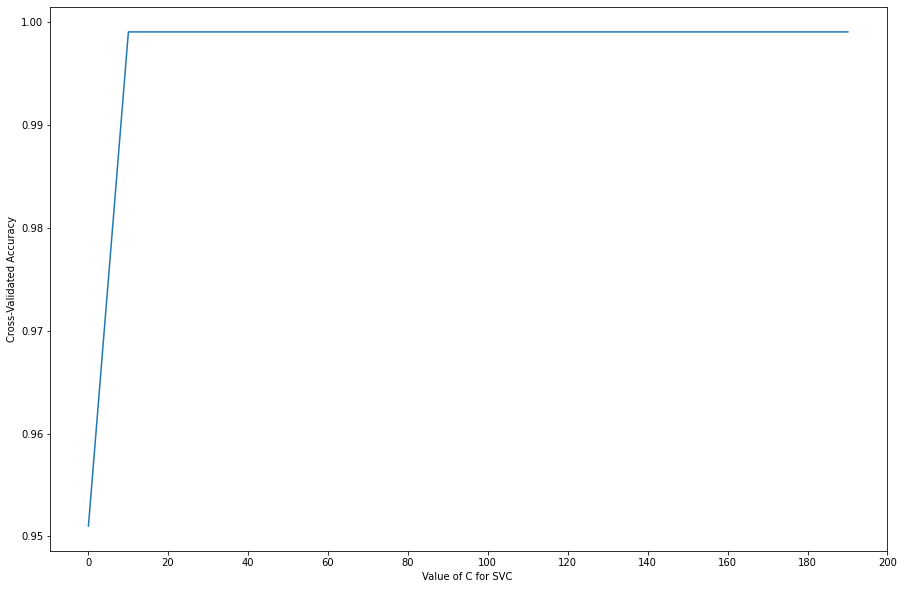

In [ ]:
C_range=list(np.arange(0.1,200,10))
acc_score=[]
for c in C_range:
    svc = SVC(kernel='rbf', C=c)
    scores = cross_val_score(svc, X_train, y_train, cv=10, scoring='accuracy')
    acc_score.append(scores.mean())
print(acc_score)   
# plot the value of C for SVM (x-axis) versus the cross-validated accuracy (y-axis)
plt.figure(figsize=(15, 10))
plt.plot(C_range,acc_score)
plt.xticks(np.arange(0.0,220,20))
plt.xlabel('Value of C for SVC ')
plt.ylabel('Cross-Validated Accuracy')

**Above C=10 accuracy remains constant, so we can choose the random value from this range.**

## Checking The Gamma hyperparameter in RBF Kernel

[0.9452380952380952, 0.9788553113553113, 1.0, 0.9932692307692308, 0.8481959706959706, 0.5600091575091575, 0.5360073260073259]


Text(0, 0.5, 'Cross-Validated Accuracy')

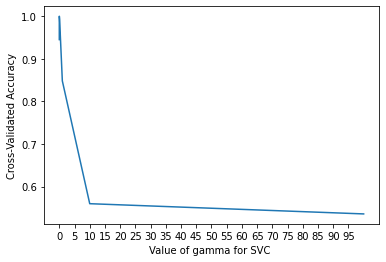

In [ ]:
gamma_range=[0.0001,0.001,0.01,0.1,1,10,100]
acc_score=[]
for g in gamma_range:
    svc = SVC(kernel='rbf', gamma=g, C=15)
    scores = cross_val_score(svc, X_train, y_train, cv=10, scoring='accuracy')
    acc_score.append(scores.mean())
print(acc_score)    

plt.plot(gamma_range,acc_score)
plt.xlabel('Value of gamma for SVC ')
plt.xticks(np.arange(0.0001,100,5))
plt.ylabel('Cross-Validated Accuracy')

**We can see that for gamma more than 2 the kernel is performing poorly. We can also see a slight dip in accuracy score when gamma is around 0. Let us look into more details for the range 0 to 5.**



[0.9135164835164835, 0.9932692307692308, 0.9807783882783884, 0.9673260073260073, 0.9519597069597069, 0.9327289377289377, 0.9154304029304028, 0.8952655677655679, 0.8827655677655677, 0.8683608058608059, 0.8481959706959706, 0.8328296703296705, 0.8241758241758242, 0.8136080586080586, 0.800164835164835, 0.7818956043956043, 0.7722893772893772, 0.7617124542124541, 0.7501739926739928, 0.7453754578754579, 0.7280860805860806, 0.7194413919413919, 0.7117765567765568, 0.7079304029304029, 0.7002564102564104, 0.6906501831501831, 0.6848992673992674, 0.6772069597069598, 0.6676007326007326, 0.6618406593406594, 0.6579945054945053, 0.6541483516483517, 0.6512637362637362, 0.6483882783882784, 0.6435805860805861, 0.6387820512820512, 0.6339743589743589, 0.6291758241758242, 0.6262912087912087, 0.6243681318681318, 0.620521978021978, 0.618598901098901, 0.6176373626373627, 0.6137912087912089, 0.6128388278388279, 0.608992673992674, 0.6080311355311355, 0.6070787545787546, 0.6042032967032966, 0.6042032967032966]


Text(0, 0.5, 'Cross-Validated Accuracy')

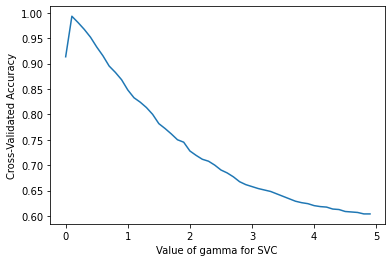

In [ ]:
gamma_range=list(np.arange(0.00001,5,0.1))
acc_score=[]
for g in gamma_range:
    svc = SVC(kernel='rbf', gamma=g, C=15)
    scores = cross_val_score(svc, X_train, y_train, cv=10, scoring='accuracy')
    acc_score.append(scores.mean())
print(acc_score)    
# plot the value of C for SVM (x-axis) versus the cross-validated accuracy (y-axis)
plt.plot(gamma_range,acc_score)
plt.xlabel('Value of gamma for SVC ')
plt.ylabel('Cross-Validated Accuracy')

**The score reaches its peak around Gamma = 0.1 and decreases steadily. Thus we should focuse on values lower than 0.02.**

[0.9135164835164835, 1.0, 0.9990384615384615, 0.9990384615384615, 0.9990384615384615, 0.9990384615384615, 0.998076923076923, 0.9951923076923077, 0.9932692307692308, 0.9932692307692308, 0.9932692307692308, 0.9932692307692308, 0.9913461538461539, 0.9913461538461539, 0.9913461538461539, 0.9903846153846153, 0.986547619047619, 0.9846245421245422, 0.9836630036630037, 0.9827014652014652]


Text(0, 0.5, 'Cross-Validated Accuracy')

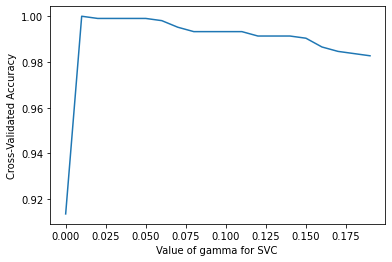

In [ ]:
gamma_range=list(np.arange(0.00001,0.2,0.01))
acc_score=[]
for g in gamma_range:
    svc = SVC(kernel='rbf', gamma=g, C=15)
    scores = cross_val_score(svc, X_train, y_train, cv=10, scoring='accuracy')
    acc_score.append(scores.mean())
print(acc_score)    
# plot the value of C for SVM (x-axis) versus the cross-validated accuracy (y-axis)
plt.plot(gamma_range,acc_score)
plt.xlabel('Value of gamma for SVC ')
plt.ylabel('Cross-Validated Accuracy')

/usr/local/lib/python3.7/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())
/usr/local/lib/python3.7/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())
/usr/local/lib/python3.7/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())
/usr/local/lib/python3.7/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(),

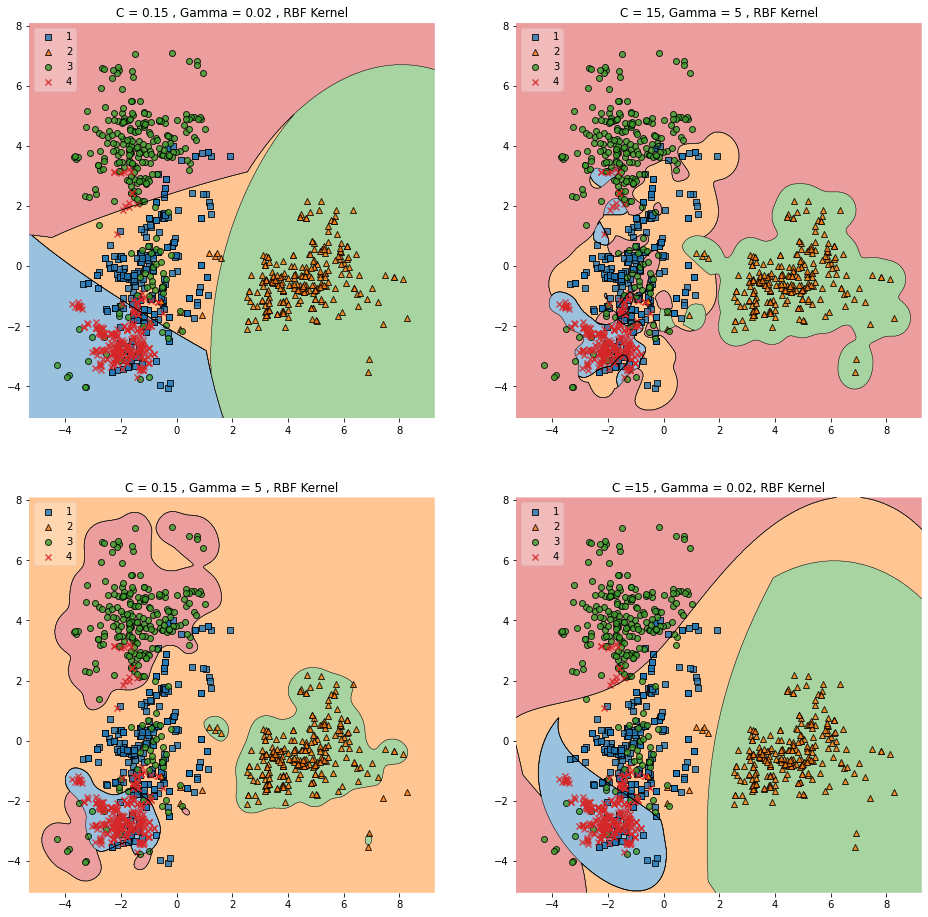

In [ ]:
gs = gridspec.GridSpec(2, 2)

fig = plt.figure(figsize=(16,16))

clf1 = SVC(C=0.15, kernel='rbf', gamma = 0.02)
clf2 = SVC(C=15, kernel='rbf', gamma = 5)
clf3 = SVC(C=0.15, kernel='rbf', gamma = 5)
clf4 = SVC(C=15, kernel='rbf', gamma = 0.02)
scatter_highlight_kwargs = {'s': 50, 'label': 'Test data', 'alpha': 0.7, 'linestyle':'-'}

labels = ['C = 0.15 , Gamma = 0.02 , RBF Kernel' , 'C = 15, Gamma = 5 , RBF Kernel', 'C = 0.15 , Gamma = 5 , RBF Kernel'  ,'C =15 , Gamma = 0.02, RBF Kernel']
for clf, lab, grd in zip([clf1, clf2, clf3, clf4],
                         labels,
                         itertools.product([0, 1], repeat=2)):

    clf.fit(X_train_pca, y_train)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X_train_pca, y=np.asarray(y_train), clf=clf, legend=2)
    plt.title(lab)

plt.show()

**For high values of Gamma we observe obvious overfitting.**

## Grid Search with 10-fold cross-validation

In [ ]:
tuned_parameters = {
    'C':  (np.arange(0.1,20,1)),
    'gamma': (np.arange(0.01,0.05,0.005)),
    'kernel':[ 'rbf' ]
}

svm_model= SVC()

model_svm = GridSearchCV(svm_model, tuned_parameters,cv=10,scoring='accuracy')
model_svm.fit(X_train, y_train)

print(model_svm.best_score_)
print(model_svm.best_params_)


1.0
{'C': 3.1, 'gamma': 0.015, 'kernel': 'rbf'}


In [ ]:
y_pred= model_svm.predict(X_test)
print(metrics.accuracy_score(y_pred,y_test))

0.9942363112391931


/usr/local/lib/python3.7/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())


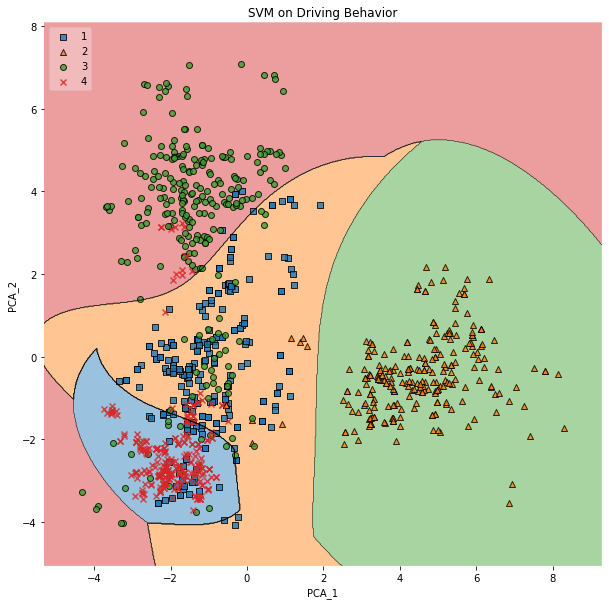

In [ ]:
model_svm.fit(X_train_pca, y_train)
# Plotting decision regions
plt.rcParams['figure.figsize'] = (10, 10)
plot_decision_regions(X_train_pca, np.asarray(y_train), clf=model_svm, legend=2)

# Adding axes annotations
plt.xlabel('PCA_1')
plt.ylabel('PCA_2')
plt.title('SVM on Driving Behavior')
plt.show()

In [ ]:
y_pred= model_svm.predict(X_test_pca)
print('SVM + PCA accuracy: ', metrics.accuracy_score(y_pred,y_test))

SVM + PCA accuracy:  0.7262247838616714


**Decision regions for test dataset**

/usr/local/lib/python3.7/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())


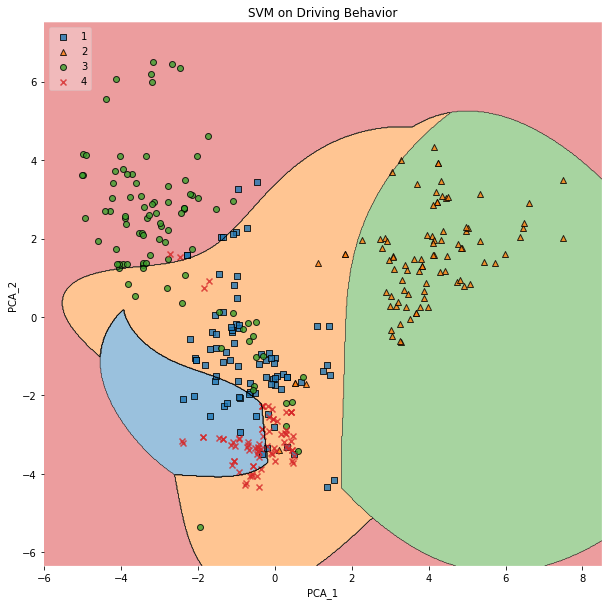

In [ ]:
X_test_pca = pca.fit_transform(X_test)


# Plotting decision regions
plt.rcParams['figure.figsize'] = (10, 10)
plot_decision_regions(X_test_pca, np.asarray(y_test), clf=model_svm, legend=2)

# Adding axes annotations
plt.xlabel('PCA_1')
plt.ylabel('PCA_2')
plt.title('SVM on Driving Behavior')
plt.show()

#RANDOM FOREST 

##Classifier with default parameters

In [ ]:
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9913544668587896


##Adjusting hyperparameters

[0.9433150183150183, 0.9461996336996336, 0.9644688644688644, 0.9711996336996336, 0.9846428571428572, 0.9923260073260073, 0.9923168498168499, 0.9932783882783882, 0.9942490842490843, 0.9951923076923077, 0.9961538461538462, 0.9942490842490843, 0.9951923076923077, 0.9952014652014652, 0.9952014652014652, 0.9952014652014652, 0.9951923076923077, 0.997124542124542, 0.9952014652014652, 0.9971153846153846, 0.9932875457875457, 0.9961538461538462, 0.9961538461538462, 0.9942307692307691, 0.9942307692307691, 0.998076923076923, 0.9952014652014652, 0.9952014652014652, 0.9942399267399267, 0.9951923076923077, 0.9961721611721611, 0.9961538461538462, 0.9961538461538462, 0.9942399267399267, 0.9951923076923077, 0.9961538461538462, 0.9961538461538462, 0.9951923076923077, 0.9942399267399267, 0.9942399267399267, 0.9971153846153846, 0.9971153846153846, 0.9942399267399267, 0.9971153846153846, 0.9961538461538462, 0.997124542124542, 0.9952014652014652, 0.9942399267399267]


Text(0, 0.5, 'Cross-Validated Accuracy')

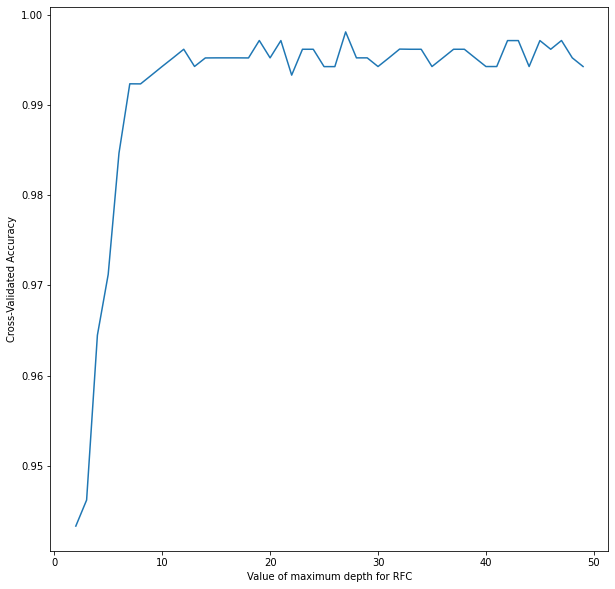

In [ ]:
depth=list(np.arange(2,50))
acc_score=[]
for d in depth:
    rfc = RandomForestClassifier(max_depth = d,  oob_score = True, n_jobs=-1)
    scores = cross_val_score(rfc, X_train, y_train, cv=10, scoring='accuracy')
    acc_score.append(scores.mean())
print(acc_score)    

plt.plot(depth, acc_score)
plt.xlabel('Value of maximum depth for RFC')
plt.ylabel('Cross-Validated Accuracy')

**Similar accuracy values are obtained for tree depht above 10. Depth value of 10 is a trade-off between accuracy and calculation speed**

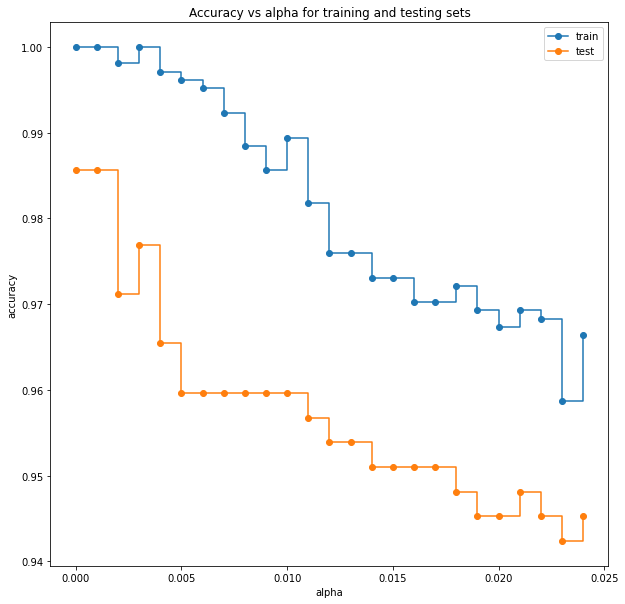

In [ ]:
ccp_alphas=list(np.arange(0.0, 0.025, 0.001))
clfs=[]
for ccp in ccp_alphas:
    clf = RandomForestClassifier(ccp_alpha = ccp, max_depth = 10,  oob_score = True, n_jobs=-1)
    clf.fit(X_train, y_train)
    clfs.append(clf)

train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]

fig, ax = plt.subplots(figsize=(10,10))
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train",
        drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test",
        drawstyle="steps-post")
ax.legend()
plt.show()

**The best score for train and test dataset is achieved witout prunning (cpp_alpha = 0.0)**

## Grid Search with 10-fold cross-validation

In [ ]:
tuned_parameters = {
    'max_depth':  (np.arange(10,15)),
    'ccp_alpha': (np.arange(0.000,0.005,0.001)),
    'criterion':['gini', 'entropy'],
    'warm_start' : [False, True],
    'oob_score' : [True], 
    'n_jobs' : [-1]
}

rfc_model= RandomForestClassifier()

model_rfc = GridSearchCV(rfc_model, tuned_parameters,cv=10,scoring='accuracy')
model_rfc.fit(X_train, y_train)

print(model_rfc.best_score_)
print(model_rfc.best_params_)

0.998076923076923
{'ccp_alpha': 0.0, 'criterion': 'entropy', 'max_depth': 10, 'n_jobs': -1, 'oob_score': True, 'warm_start': False}



**Decision regions for train dataset**

/usr/local/lib/python3.7/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())


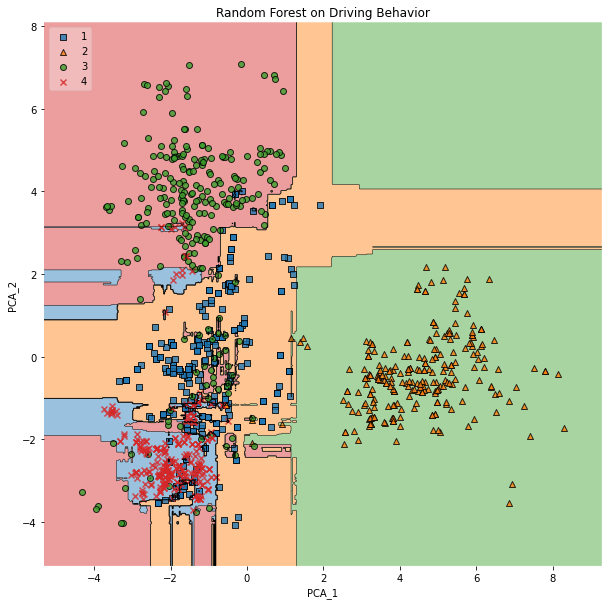

In [ ]:
model_rfc.fit(X_train_pca, y_train)
# Plotting decision regions
plt.rcParams['figure.figsize'] = (10, 10)
plot_decision_regions(X_train_pca, np.asarray(y_train), clf=model_rfc, legend=2)

# Adding axes annotations
plt.xlabel('PCA_1')
plt.ylabel('PCA_2')
plt.title('Random Forest on Driving Behavior')
plt.show()

In [ ]:
y_pred= model_rfc.predict(X_test_pca)
print('RFC + PCA accuracy: ', metrics.accuracy_score(y_pred,y_test))

RFC + PCA accuracy:  0.5763688760806917





**Decision regions for test dataset**

/usr/local/lib/python3.7/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())


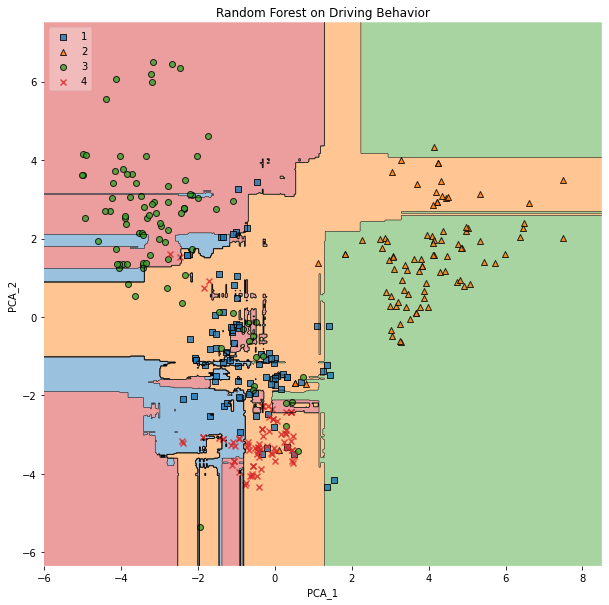

In [ ]:

# Plotting decision regions
plt.rcParams['figure.figsize'] = (10, 10)
plot_decision_regions(X_test_pca, np.asarray(y_test), clf=model_rfc, legend=2)

# Adding axes annotations
plt.xlabel('PCA_1')
plt.ylabel('PCA_2')
plt.title('Random Forest on Driving Behavior')
plt.show()

#XGBOOST

##Removing ouliers with UMAP and DBSCAN 

(-15.0, 15.0)

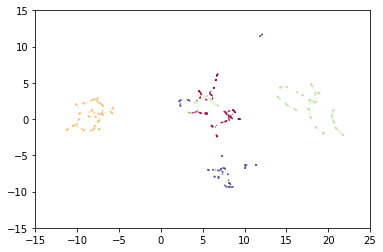

In [62]:
scaler = StandardScaler()
scaler.fit(df_clear.iloc[:, 1:])
X = scaler.transform(df_clear.iloc[:, 1:])

standard_embedding = umap.UMAP(random_state=33).fit_transform(X)
plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], c=df_clear['Target'], s=0.1, cmap='Spectral')
ax = plt.gca()
ax.set_xlim([-15, 25])
ax.set_ylim([-15, 15])

(-15.0, 15.0)

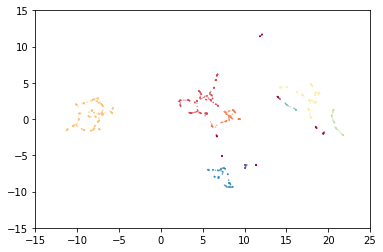

In [68]:
dbscan=DBSCAN(eps = 1.05, min_samples = 20)
dbscan.fit_predict(standard_embedding)
plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], c=dbscan.labels_, s=0.1, cmap='Spectral');
ax = plt.gca()
ax.set_xlim([-15, 25])
ax.set_ylim([-15, 15])

(-15.0, 15.0)

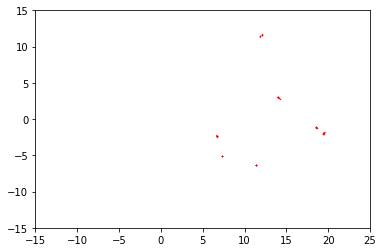

In [69]:
standard_embedding = standard_embedding[dbscan.labels_ == -1]
plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], c='r', s=0.1, cmap='Spectral');
ax = plt.gca()
ax.set_xlim([-15, 25])
ax.set_ylim([-15, 15])

In [70]:
df_clear = df_clear.iloc[dbscan.labels_!= -1]

##Dealing with unbalanced data

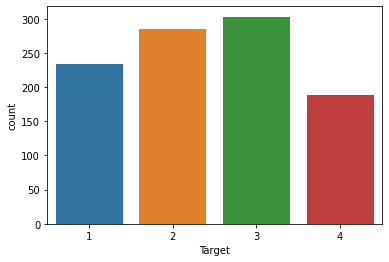

In [71]:
sns.countplot(x='Target',data=df_clear)

In [74]:
sample_weights = compute_sample_weight(
    class_weight='balanced',
    y=df_clear['Target'] 
)

TO DO:##Running SVM with default hyperparamters

In [ ]:
X=df_clear.iloc[:, 1:]
y=df_clear.iloc[:,0]

## Splitting

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=33)


TO DO: XGBOOST (DAY 5)




In [ ]:
#xgb_classifier.fit(X, y, sample_weight=sample_weights)

# TO DO: ROC CURVE FOR DIFFERENT METHODS